In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
import warnings
from sklearn.preprocessing import PolynomialFeatures
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_predict
warnings.filterwarnings('ignore')

# Preprocessing

In [ ]:
COLUMNS_TO_NORMALIZE = ['water_temperature_50m', 'salinity_50m', 'oxygen_saturation_50m',
                      'seafloor_pressure', 'plankton_density', 'perceived_water_density']

COLUMNS_TO_FIX_COMA = ['oxygen_saturation_50m', 'perceived_water_density', 'sediment_deposition',
                    'dissolved_gas_pressure','current_turbulence','sediment_porosity_0_to_10cm',
                    'sediment_porosity_10_to_30cm','sediment_porosity_30_to_100cm','sediment_porosity_100_to_250cm',
                    'perpendicular_light_intensity','thermal_emissions']


In [ ]:
def clean_data(df):
    df_clean = df.copy()

    # Convert datetime
    if 'depth_reading_time' in df_clean.columns:
        df_clean['depth_reading_time'] = pd.to_datetime(df_clean['depth_reading_time'], errors='coerce')

    # Format comma-separated values
    for col in COLUMNS_TO_FIX_COMA:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].apply(
                lambda x: float(str(x).replace(',', '.')) if pd.notna(x) else x
            )
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # Handle outliers with robust approach
    def handle_outliers(df, column, method='cap'):
        if column not in df.columns or not pd.api.types.is_numeric_dtype(df[column]):
            return df

        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        if method == 'cap':
            df[column] = df[column].clip(lower_bound, upper_bound)
        elif method == 'remove':
            df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

        return df


    numeric_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        df_clean = handle_outliers(df_clean, col, method='cap')

    return df_clean


# imputation
def impute(df):
    for name in df.select_dtypes("number").columns:
        df[name] = df[name].fillna(df[name].median())
    for name in df.select_dtypes("category").columns:
        df[name] = df[name].fillna(df[name].mode().iloc[0])

    return df

def advanced_impute(df):
    physical_features = ['water_temperature_50m', 'salinity_50m', 'perceived_water_density']
    current_features = ['current_velocity_near_surface', 'current_velocity_deep',
                      'current_direction_near_surface', 'current_direction_deep']
    sediment_features = ['sediment_temperature_0_to_10cm', 'sediment_temperature_10_to_30cm',
                       'sediment_temperature_30_to_100cm', 'sediment_temperature_100_to_250cm']
    light_features = ['blue_light_penetration', 'downwelling_light', 'scattered_light',
                     'perpendicular_light_intensity']

    df_imputed = df.copy()

    imputer = KNNImputer(n_neighbors=5)
    feature_groups = [physical_features, current_features, sediment_features, light_features]

    for group in feature_groups:
        available_cols = [col for col in group if col in df.columns]
        if len(available_cols) >= 2:
            missing_mask = df[available_cols].isna().any(axis=1)
            if missing_mask.sum() > 0:
                missing_indices = df.index[missing_mask]

                data_for_imputation = df[available_cols]

                imputed_values = imputer.fit_transform(data_for_imputation)

                df_imputed.loc[missing_indices, available_cols] = imputed_values[missing_mask]

    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        if df_imputed[col].isna().any():
            df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())

    for col in df.select_dtypes(include=['object', 'category']).columns:
        if df_imputed[col].isna().any():
            df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mode().iloc[0])

    return df_imputed


# normalization min max and power transform
def normalize_features(df):
    """Apply appropriate normalization to features"""
    df_norm = df.copy()

    for column in COLUMNS_TO_NORMALIZE:
        if column in df_norm.columns and pd.api.types.is_numeric_dtype(df_norm[column]):
            min_val = df_norm[column].min()
            max_val = df_norm[column].max()
            df_norm[f"{column}_normalized"] = (df_norm[column] - min_val) / (max_val - min_val)

    skewed_features = []
    for col in df_norm.select_dtypes(include=['float64', 'int64']).columns:
        skewness = df_norm[col].skew()
        if abs(skewness) > 1.0:
            skewed_features.append(col)

    if skewed_features:
        pt = PowerTransformer(method='yeo-johnson', standardize=True)
        df_norm[skewed_features] = pt.fit_transform(df_norm[skewed_features])

    return df_norm


In [ ]:
def preprocess_data(df):
    df = clean_data(df)

    for column in COLUMNS_TO_NORMALIZE:
        if column in df.columns and pd.api.types.is_numeric_dtype(df[column]):
            df = normalize_features(df)
        else:
            print(f"⚠️  Lewati normalisasi '{column}' karena bukan numerik.")

    return df

# Feature Engineering

In [ ]:
def create_basic_features(df):
    # datetime features
    if 'depth_reading_time' in df.columns:
        df['year'] = df['depth_reading_time'].dt.year
        df['month'] = df['depth_reading_time'].dt.month
        df['day'] = df['depth_reading_time'].dt.day
        df['hour'] = df['depth_reading_time'].dt.hour
        df['day_of_year'] = df['depth_reading_time'].dt.dayofyear
        df['is_weekend'] = df['depth_reading_time'].dt.dayofweek >= 5

        df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
        df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
        df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

        def assign_day_period(hour):
            if 5 <= hour <= 10:
                return 'Morning'
            elif 11 <= hour <= 15:
                return 'Noon'
            elif 16 <= hour <= 18:
                return 'Evening'
            else:
                return 'Night'
        df['day_period'] = df['hour'].apply(assign_day_period)
        df['day_period'] = df['day_period'].astype('category')

        df = df.drop(columns=['depth_reading_time'])

    # total_light_exposure
    light_columns = ['blue_light_penetration', 'downwelling_light',
                     'scattered_light', 'perpendicular_light_intensity']
    if all(col in df.columns for col in light_columns):
        df['total_light_exposure'] = df[light_columns].sum(axis=1)

    # encoding
    cat_columns = df.select_dtypes(include=['category']).columns
    for col in cat_columns:
        df[col] = df[col].cat.codes

    return df

def add_temporal_features(df):
    """Extract more advanced temporal features from the datetime columns"""
    df_new = df.copy()

    # Fourier features for cyclical patterns
    if 'hour' in df.columns:
        # Higher frequency components
        for period in [6, 8, 12]:
            df_new[f'hour_sin_{period}h'] = np.sin(2 * np.pi * df['hour'] / period)
            df_new[f'hour_cos_{period}h'] = np.cos(2 * np.pi * df['hour'] / period)

    if 'day_of_year' in df.columns:
        # Seasonal components
        for period in [30, 90, 180]:  # Monthly, quarterly, half-yearly
            df_new[f'day_sin_{period}d'] = np.sin(2 * np.pi * df['day_of_year'] / period)
            df_new[f'day_cos_{period}d'] = np.cos(2 * np.pi * df['day_of_year'] / period)

    return df_new

def create_advanced_features(df):
    """Create sophisticated oceanographic features based on domain knowledge"""
    X = pd.DataFrame(index=df.index)

    # 1. Physical property relationships
    if all(col in df.columns for col in ['perceived_water_density', 'water_temperature_50m']):
        X["density_temp_ratio"] = df["perceived_water_density"] / (df["water_temperature_50m"] + 273.15)  # Use Kelvin

    if all(col in df.columns for col in ['seafloor_pressure', 'perceived_water_density']):
        X["pressure_density_ratio"] = df["seafloor_pressure"] / (df["perceived_water_density"] + 0.001)

    # 2. Oceanographic indices
    if all(col in df.columns for col in ['Brunt_Vaisala_frequency_squared (s-2)', 'mixed_layer_depth (m)']):
        X["stratification_index"] = df["Brunt_Vaisala_frequency_squared (s-2)"] * df["mixed_layer_depth (m)"]

    if all(col in df.columns for col in ['sound_speed_water (m s-1)', 'perceived_water_density']):
        X["acoustic_density_factor"] = df["sound_speed_water (m s-1)"] * df["perceived_water_density"]

    # 3. Ecological relationships
    if all(col in df.columns for col in ['chlorophyll_a_concentration (mg m-3)', 'nitrate_concentration (µmol L-1)']):
        X["productivity_index"] = df["chlorophyll_a_concentration (mg m-3)"] / (df["nitrate_concentration (µmol L-1)"] + 0.001)

    if all(col in df.columns for col in ['downwelling_light', 'chlorophyll_a_concentration (mg m-3)']):
        X["light_productivity_ratio"] = df["downwelling_light"] / (df["chlorophyll_a_concentration (mg m-3)"] + 0.001)

    # 4. Wave-current interactions
    if all(col in df.columns for col in ['significant_wave_height (m)', 'current_velocity_near_surface']):
        X["wave_current_interaction"] = df["significant_wave_height (m)"] * df["current_velocity_near_surface"]

    # 5. Current-driven pressure effects
    if all(col in df.columns for col in ['current_velocity_deep', 'perceived_water_density']):
        X["current_pressure_effect"] = df["current_velocity_deep"]**2 * df["perceived_water_density"]

    # 6. Temperature gradients and thermal dynamics
    if all(col in df.columns for col in ['sediment_temperature_0_to_10cm', 'sediment_temperature_100_to_250cm']):
        X["sediment_temp_gradient"] = df["sediment_temperature_100_to_250cm"] - df["sediment_temperature_0_to_10cm"]

    # 7. Porosity and permeability proxies
    if all(col in df.columns for col in ['sediment_porosity_0_to_10cm', 'sediment_porosity_100_to_250cm']):
        X["sediment_porosity_gradient"] = df["sediment_porosity_100_to_250cm"] - df["sediment_porosity_0_to_10cm"]

    # 8. Nutrient ratios important for oceanography
    if all(col in df.columns for col in ['nitrate_concentration (µmol L-1)', 'phosphate_concentration (µmol L-1)']):
        X["n_p_ratio"] = df["nitrate_concentration (µmol L-1)"] / (df["phosphate_concentration (µmol L-1)"] + 0.001)

    if all(col in df.columns for col in ['silicate_concentration (µmol L-1)', 'nitrate_concentration (µmol L-1)']):
        X["si_n_ratio"] = df["silicate_concentration (µmol L-1)"] / (df["nitrate_concentration (µmol L-1)"] + 0.001)

    # 9. Carbon chemistry indicators
    if all(col in df.columns for col in ['total_alkalinity (µmol kg-1)', 'dissolved_inorganic_carbon (µmol kg-1)']):
        X["buffering_capacity"] = df["total_alkalinity (µmol kg-1)"] / (df["dissolved_inorganic_carbon (µmol kg-1)"] + 0.001)

    if all(col in df.columns for col in ['partial_pressure_CO2 (µatm)', 'pH']):
        X["co2_pH_interaction"] = df["partial_pressure_CO2 (µatm)"] * df["pH"]

    # 10. Current shear and turbulence proxies
    if all(col in df.columns for col in ['current_velocity_near_surface', 'current_velocity_deep', 'mixed_layer_depth (m)']):
        X["depth_current_shear"] = (df["current_velocity_near_surface"] - df["current_velocity_deep"]) / (df["mixed_layer_depth (m)"] + 0.1)

    # 11. Non-linear transformations of key variables
    if 'seafloor_pressure' in df.columns:
        X["pressure_squared"] = df["seafloor_pressure"]**2

    if 'water_temperature_50m' in df.columns:
        X["temp_cubed"] = df["water_temperature_50m"]**3

    # 12. Interaction terms between key variables
    if all(col in df.columns for col in ['water_temperature_50m', 'salinity_50m']):
        X["temp_salinity_interaction"] = df["water_temperature_50m"] * df["salinity_50m"]
        X["temp_salinity_quadratic"] = df["water_temperature_50m"]**2 * df["salinity_50m"]

    # 13. Environmental stress indices
    if all(col in df.columns for col in ['turbidity (NTU)', 'oxygen_saturation_50m']):
        X["environmental_stress_index"] = df["turbidity (NTU)"] / (df["oxygen_saturation_50m"] + 0.001)

    # 14. Plankton productivity interactions
    if all(col in df.columns for col in ['plankton_density', 'chlorophyll_a_concentration (mg m-3)']):
        X["plankton_chlorophyll_interaction"] = df["plankton_density"] * df["chlorophyll_a_concentration (mg m-3)"]

    # 15. Dynamic pressure components
    if all(col in df.columns for col in ['current_velocity_near_surface', 'perceived_water_density']):
        X["dynamic_pressure_surface"] = 0.5 * df["perceived_water_density"] * df["current_velocity_near_surface"]**2

    if all(col in df.columns for col in ['current_velocity_deep', 'perceived_water_density']):
        X["dynamic_pressure_deep"] = 0.5 * df["perceived_water_density"] * df["current_velocity_deep"]**2

    return X

def enhanced_light_exposure_reconstruction(df):
    """Advanced reconstruction of total_light_exposure using physical relationships"""

    # Basic components
    light_features = ['blue_light_penetration', 'downwelling_light',
                     'scattered_light', 'perpendicular_light_intensity']

    if all(f in df.columns for f in light_features):
        df['total_light_exposure_reconstructed'] = (
            df['blue_light_penetration'] * 0.35 +  
            df['downwelling_light'] * 0.40 +       
            df['scattered_light'] * 0.15 +        
            df['perpendicular_light_intensity'] * 0.10 
        )

        # Adjust for water clarity using turbidity
        if 'turbidity (NTU)' in df.columns:
            clarity_factor = np.exp(-0.2 * df['turbidity (NTU)']) 
            df['total_light_exposure_reconstructed'] *= clarity_factor

        # Daily cycle modulation
        if 'hour' in df.columns:
            time_factor = -((df['hour'] - 12)**2) / 40 + 1 
            time_factor = time_factor.clip(0.1, 1.0)
            df['total_light_exposure_reconstructed'] *= time_factor

    return df

def add_polynomial_features(train, test, top_features, degree=2):
    X_train = train.copy()
    X_test = test.copy()

    if len(top_features) > 20:
        top_features = top_features[:20]

    X_top_train = X_train[top_features]
    X_top_test = X_test[top_features]

    poly = PolynomialFeatures(degree=degree, include_bias=False, interaction_only=True)
    poly.fit(X_top_train)

    poly_features_train = poly.transform(X_top_train)
    poly_features_test = poly.transform(X_top_test)

    feature_names = poly.get_feature_names_out(top_features)
    train_df = pd.DataFrame(poly_features_train, columns=feature_names, index=train.index)
    test_df = pd.DataFrame(poly_features_test, columns=feature_names, index=test.index)

    interaction_features = [col for col in train_df.columns if ' ' in col]

    return train_df[interaction_features], test_df[interaction_features]


# Feature Selection

In [ ]:
def select_optimal_features(X, y, threshold=0.001):
    from sklearn.feature_selection import RFECV, SelectFromModel
    from sklearn.ensemble import RandomForestRegressor

    rf = XGBRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)

    importances = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    selector = SelectFromModel(rf, threshold=threshold, prefit=True)
    X_selected = selector.transform(X)
    selected_features = X.columns[selector.get_support()]

    print(f"Selected {len(selected_features)} out of {X.shape[1]} features")

    # Recursive feature elimination with cross-validation
    if X.shape[1] < 50:  
        rfecv = RFECV(estimator=rf, step=1, cv=5, scoring='r2', n_jobs=-1)
        rfecv.fit(X, y)
        X_rfecv = rfecv.transform(X)
        rfecv_features = X.columns[rfecv.support_]
        print(f"RFECV selected {len(rfecv_features)} features")
        return X_rfecv, rfecv_features

    return X_selected, selected_features

# Data Preparation

In [ ]:
def load_data():
    data_dir = '/content/content/'

    train = pd.read_csv(data_dir + 'train.csv', index_col="measurement_id")
    test = pd.read_csv(data_dir + 'test.csv', index_col="measurement_id")
    return train, test

In [ ]:
def data_preparation(train, test, target_column='hydrostatic_pressure'):
    X = train.copy()
    y = X.pop(target_column)
    X_test = test.copy()

    X_combined = pd.concat([X, X_test])

    # Preprocessing
    X_combined = clean_data(X_combined)
    X_combined = advanced_impute(X_combined)
    X_combined = create_basic_features(X_combined)
    X_combined = add_temporal_features(X_combined)
    X_combined = enhanced_light_exposure_reconstruction(X_combined)

    advanced_features = create_advanced_features(X_combined)
    if not advanced_features.empty:
        X_combined = X_combined.join(advanced_features)

    X_combined = normalize_features(X_combined)

    # Periksa dan tangani kolom non-numerik
    for col in X_combined.columns:
        if not pd.api.types.is_numeric_dtype(X_combined[col]):
            print(f"Warning: Kolom {col} bukan numerik.")

    # Periksa kolom dengan variansi nol
    for col in X_combined.columns:
        if X_combined[col].nunique() <= 1:
            print(f"Warning: Kolom {col} memiliki variansi 0. Menghapus kolom...")
            X_combined = X_combined.drop(columns=[col])

    # Pemisahan data
    train_processed = X_combined.iloc[:len(train)].copy()
    train_processed[target_column] = y.values
    test_processed = X_combined.iloc[len(train):].copy()

    return train_processed, test_processed

In [ ]:
train, test = load_data()
train_processed, test_processed = data_preparation(train, test)

In [ ]:
print(f'train : {train_processed.shape}, test : {test_processed.shape}')

train : (15321, 105), test : (6567, 104)


In [ ]:
cat_bool_columns = train_processed.select_dtypes(include=['category','bool','object']).columns.tolist()
print("Categorical and bool columns:", cat_bool_columns)

Categorical and bool columns: ['is_weekend']


In [ ]:
# Split train_processed into features and target

X_train = train_processed.drop(columns=['hydrostatic_pressure'])
y_train = train_processed['hydrostatic_pressure']
X_test = test_processed.copy()

# Train and Predict

In [ ]:
catboost_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=8,
    l2_leaf_reg=5,
    border_count=128,
    subsample=0.8,
    rsm=0.9,
    random_state=42,
    verbose=0,
)

In [ ]:
def evaluate_model_with_cross_validation(model, X, y, cv=5):
    """
    Evaluate model performance with cross-validation and detailed metrics
    """
    if isinstance(model, CatBoostRegressor):
        cat_features = [i for i, col in enumerate(X.columns) if
                        pd.api.types.is_categorical_dtype(X[col]) or
                        pd.api.types.is_object_dtype(X[col]) or
                        pd.api.types.is_bool_dtype(X[col])]

        params = model.get_params()

        # cat_features params 
        if 'cat_features' in params:
            if cat_features:
                params['cat_features'] = cat_features
            else:
                del params['cat_features']
        elif cat_features:
            params['cat_features'] = cat_features


        print(f"Using cat_features: {params['cat_features'] if 'cat_features' in params else 'None'}")

        model = CatBoostRegressor(**params)

    cv_preds = cross_val_predict(model, X, y, cv=cv)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y, cv_preds))
    r2 = r2_score(y, cv_preds)
    mae = mean_absolute_error(y, cv_preds)

    print(f"Cross-Validation Results (CV={cv}):")
    print(f"RMSE: {rmse:.6f}")
    print(f"R²: {r2:.6f}")
    print(f"MAE: {mae:.6f}")

    # Visualize results
    plt.figure(figsize=(14, 5))

    # Actual vs Predicted
    plt.subplot(1, 2, 1)
    plt.scatter(y, cv_preds, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')

    # Residuals
    plt.subplot(1, 2, 2)
    residuals = y - cv_preds
    plt.scatter(cv_preds, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residuals Plot')

    plt.tight_layout()  
    plt.show()

    return rmse, r2, mae


Detected categorical feature indices: [56]
Categorical feature names: ['is_weekend']
                                          Feature  Importance
90                               pressure_squared   19.463230
101                  seafloor_pressure_normalized   18.844286
5                               seafloor_pressure   16.254513
66                                   hour_sin_12h    4.577905
23                 sediment_porosity_100_to_250cm    4.401013
51                                           year    2.846189
79                             productivity_index    2.268652
19              sediment_temperature_100_to_250cm    1.922417
59                                       hour_sin    1.729472
18               sediment_temperature_30_to_100cm    1.662296
21                   sediment_porosity_10_to_30cm    1.541075
55                                    day_of_year    1.261597
70                                    day_sin_90d    1.188414
72                                   day_sin_18

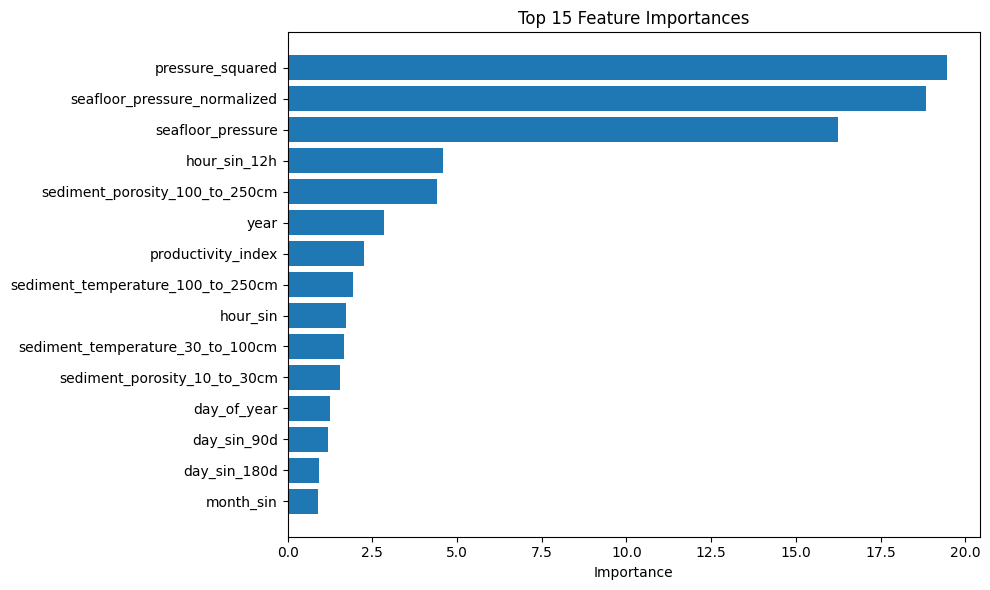

In [ ]:
pd.set_option('display.max_rows', None)

# Deteksi kolom kategorikal di X_train
cat_features = [i for i, col in enumerate(X_train.columns) if
                pd.api.types.is_categorical_dtype(X_train[col]) or
                pd.api.types.is_object_dtype(X_train[col]) or
                pd.api.types.is_bool_dtype(X_train[col])]

params = catboost_model.get_params()

# cat_features params
if 'cat_features' in params:
    if cat_features:
        params['cat_features'] = cat_features
    else:
        del params['cat_features']
else:
    if cat_features:
        params['cat_features'] = cat_features

catboost_model = CatBoostRegressor(**params)

catboost_model.fit(X_train, y_train)

# feature importances
feature_names = X_train.columns
importances = catboost_model.feature_importances_
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'][:15][::-1], feat_imp['Importance'][:15][::-1])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

In [ ]:
top_20_features = feat_imp['Feature'].head(20).tolist()
train_final, test_final = add_polynomial_features(X_train, X_test, top_20_features)

In [ ]:
# optimal feature selection

X_train_selected, selected_features = select_optimal_features(train_final, y_train, threshold=0.001)
train_final_selected = train_final[selected_features]
X_test_selected = test_final[selected_features]
train_final_selected.index = train_final.index
X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)

Selected 100 out of 190 features


In [ ]:

best_model = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.06317649508181446,
    depth=9,
    l2_leaf_reg=0.48022672681163453,
    border_count=176,
    bagging_temperature=0.6608341245724981,
    random_strength=0.8772083475373182,
    subsample=0.9673273228480513,
    colsample_bylevel=0.641906388550445,
    min_data_in_leaf=14,
    verbose=0,
    random_state=42
)


                                              Feature  Importance
2                               pressure_squared year   10.025098
14  seafloor_pressure_normalized sediment_temperat...    9.035021
11                  seafloor_pressure_normalized year    8.370726
20  seafloor_pressure_normalized sediment_temperat...    8.141808
12  seafloor_pressure_normalized sediment_temperat...    7.686598
0       pressure_squared seafloor_pressure_normalized    5.795238
10  seafloor_pressure_normalized sediment_porosity...    3.697336
4   pressure_squared sediment_temperature_100_to_2...    1.678750
33                sediment_porosity_100_to_250cm year    1.599599
16           seafloor_pressure_normalized day_of_year    1.352082
34  sediment_porosity_100_to_250cm productivity_index    1.314070
65                      hour_sin total_light_exposure    1.241550
3                 pressure_squared productivity_index    1.191839
40  sediment_porosity_100_to_250cm total_light_exp...    1.094042
39  sedime

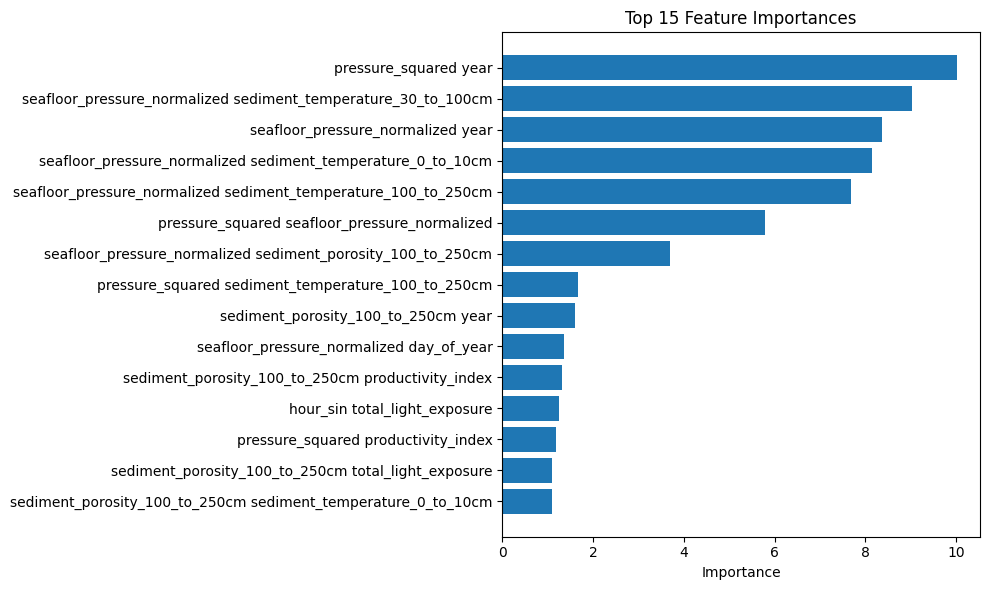

In [ ]:
# Train model
best_model.fit(X_train_selected, y_train)

# best model feature importances
feature_names = X_train_selected.columns
importances = best_model.feature_importances_
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp)
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'][:15][::-1], feat_imp['Importance'][:15][::-1])  # Top 15 fitur
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

Using cat_features: None
Cross-Validation Results (CV=5):
RMSE: 0.000418
R²: 0.956840
MAE: 0.000210


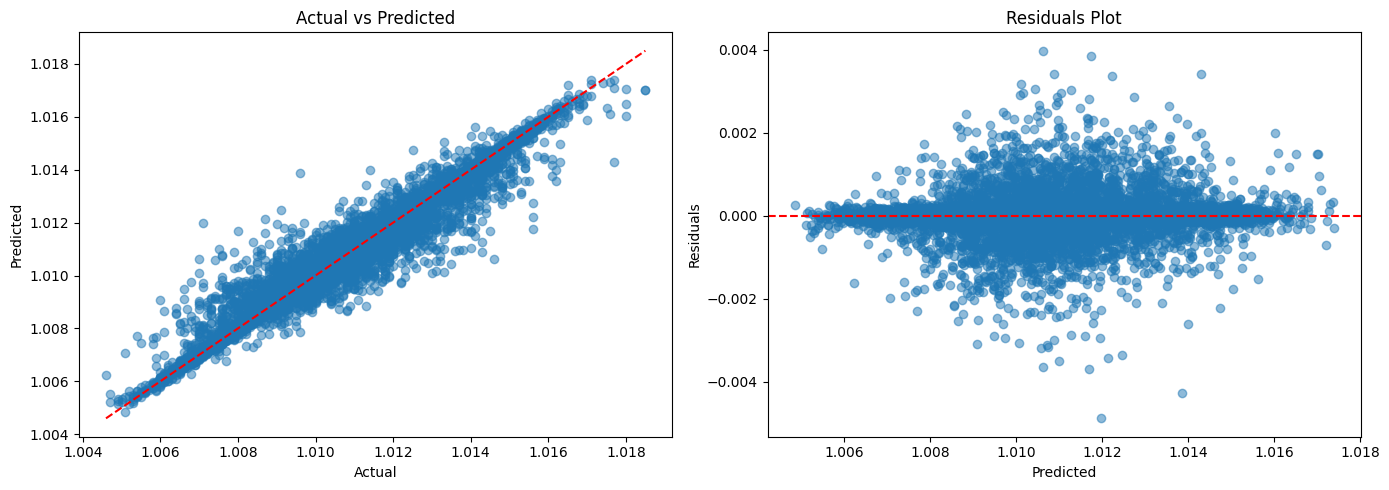

In [ ]:
rmse, r2, mae = evaluate_model_with_cross_validation(best_model,X_train_selected, y_train, cv=5)


In [ ]:
y_pred = best_model.predict(X_test_selected)

# Submission

In [ ]:
def make_submisson():
    output = pd.DataFrame({'measurement_id': X_test_selected.index, 'hydrostatic_pressure': y_pred})
    output.to_csv('submission.csv', index=False)
    print("Your submission was successfully saved!")

In [ ]:
make_submisson()

Your submission was successfully saved!
